# Source code : https://github.com/ambareeshsrja16/Python-Module-for-Missing-Data-Imputation

In [1]:
# For implementation on cluster
import torch
torch.multiprocessing.set_start_method("spawn")

In [2]:
import utils
import pandas as pd

In [3]:
#Test
filename = "merge_df.csv"
df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',') 

INFO:root:Input filename has to be space separated data


In [4]:
df1 = df.drop(['cutoff'],axis=1)
#df = utils.get_dataframe_from_csv(filename, header_row=0, sep=',').iloc[:,:-1]  #remove label

In [5]:
df.isnull().sum()

소요시간                          0
RT_A3                         0
RT_A4                         0
RT_A5                         0
RT_A8                         0
                             ..
AntiSaccade5.Velocity:std    34
AntiSaccade5.Velocity:min    19
AntiSaccade5.Velocity:max    19
Key                           0
cutoff                        0
Length: 252, dtype: int64

In [6]:
#Neuropsychology 피처
ne = ['소요시간',
 'RT_A3',
 'RT_A4',
 'RT_A5',
 'RT_A8',
 'RT_A10',
 '소요시간.1',
 'RT_B1',
 'RT_B2',
 'RT_B3',
 'RT_B5',
 'RT_B9',
 'RT_A_median',
 'RT_A_sd',
 'RT_A_min',
 'RT_A_max',
 'RT_B_sum',
 'RT_B_median',
 'RT_B_sd',
 'RT_B_min',
 'RT_B_max',
 '정답수.2',
 'cal10.1',
 'RT_cal1',
 'RT_cal2',
 'RT_cal3',
 'RT_cal4',
 'RT_cal6',
 'RT_cal7',
 'RT_cal8',
 'RT_cal9',
 'RT_cal10',
 'RT_cal12',
 'RT_cal_sum',
 'RT_cal_median',
 '소요시간.2',
 '정답수.3',
 'RT_sa1',
 'RT_sa2',
 'RT_sa3',
 'RT_sa4',
 'RT_sa5',
 'RT_sa6',
 'RT_sa_sum',
 'RT_sa_mean',
 'RT_sa_sd',
 'RT_sa_min',
 'RT_sa_max',
 '소요시간.5',
 '소요시간.6',
 '소요시간.7', 'Key']
n_df = df1[ne]

In [7]:
#SP 결측치처리
ls = []

for i in df1.columns:
    if 'SP' in i:
        ls.append(i)
        
sp_df = df1[ls]

m_df = pd.concat([n_df, sp_df], axis=1)

m_df.isnull().sum()

소요시간                    0
RT_A3                   0
RT_A4                   0
RT_A5                   0
RT_A8                   0
                       ..
SP3.InitAccel:max       6
SP3.Velocity:mean       6
SP3.Velocity:median     6
SP3.Velocity:std       10
SP3.Velocity:min        6
Length: 97, dtype: int64

In [8]:
train_df = m_df.dropna(axis=0)
print(m_df.shape)
print(train_df.shape)

(289, 97)
(277, 97)


### 1.1.2. Inducing missingness

After dataset loading, start with inducing missingness. 

To start off, introduce simple random missing patterns (Missing Completely At Random), i.e. sample half of the variables and set observations in those variables to missing if an appended random uniform vector has value less than a certain threshhold. WIth threshold of 0.2, the procedure should introduce about 20% missingness.

In [9]:
loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)

(12, 97)


# 2. Modelling

Proceed to modelling.

In R:
Start with initializing 'h2o' package and then reading the training and test datasets as the 'h2o's supported format.
Then run imputation model multiple times as each new start would initialize the weights with different values.<br>
Info at: <br>
[h2o](https://cran.r-project.org/web/packages/h2o/h2o.pdf) package offers an easy to use function for implementing autoencoders. 
More information is available at this [link](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/DeepLearningBooklet.pdf).

In Python: Using PyTorch to create the DAE, and train using the Adam optimizer from PyTorch

In [10]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.functional as F

In [11]:
#Settings for device, randomization seed, default tensor type, kwargs for memory #DevSeedTensKwargs
RANDOM_SEED = 18
np.random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    kwargs = {'num_workers':4, 'pin_memory' :True}
else:
    device = 'cpu'
    torch.manual_seed(RANDOM_SEED)
    torch.set_default_tensor_type(torch.FloatTensor)
    kwards = {}

In [12]:
import dataset_module
import Modelling
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
trainset

Dataframe Size:277, Perc of NaNs: 0.00

In [13]:
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()))
net

DenoisingAutoEncoder(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear_layer_list): ModuleList(
    (0): Linear(in_features=96, out_features=103, bias=True)
    (1): Linear(in_features=103, out_features=110, bias=True)
    (2): Linear(in_features=110, out_features=117, bias=True)
    (3): Linear(in_features=117, out_features=110, bias=True)
    (4): Linear(in_features=110, out_features=103, bias=True)
    (5): Linear(in_features=103, out_features=96, bias=True)
  )
)

# 3. Training

In [14]:
import torch.utils.data as td
from torch.optim import Adam

LR = 1e-3
DATAPOINTS = len(trainset) 
BATCH_SIZE = 512 
BATCHES = DATAPOINTS/BATCH_SIZE
VARIABLES  = len(trainset.variables()) #9


import Modelling
net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)

criterion = nn.MSELoss()
net = net.to(device) 

trainset = dataset_module.DataSetForImputation(train_df, normalize=True)
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)

277
12


In [15]:
import os
from tqdm import tqdm_notebook as tqdm
def train_model(start_steps = 0, end_steps = 5, net=None, model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout", train_loader = train_loader, val_loader = val_loader, logger_level = 20):
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)

    NaN_flag = False
    
    for epoch in tqdm(range(start_steps, end_steps)):
        count = epoch-start_steps+1
        net.train()
        #Epoch begins
        epoch_loss = 0.0
        for x, d in tqdm(train_loader):
            # Normalize between [0,1] for better convergence 
            original_x = x
            x[torch.isnan(x)]=0   #If an entire column is zero, division by 0, replace NaNs with zero
            d[torch.isnan(d)]=0 

            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            with torch.no_grad():
                d = d.to(device, dtype=torch.float32)
            y = net(x)
            loss = torch.sqrt(criterion(y, d))   #RMSE Loss   
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            #Break if NaN encountered
            if torch.isnan(loss) or torch.isinf(loss):
                logging.info(f"Loss value: {loss.item()}")
                logging.info("NaN/inf occured at:")
                logging.info(f"{x}\n")
                logging.info(f"{d}\n")
                logging.info(f"Original x was : {original_x}")
                NaN_flag = True
                break

            logging.debug(f"Count: {count}, Loss :{loss}")
            
        if NaN_flag: break   #Stop training if NaN encountered
        
        #Print to screen every few epochs    
        if count%LOG_INTERVAL == 0:
            print(f"Epoch number:{epoch} Loss: {epoch_loss:.4f}")  
            
        #Training artifacts
        if model_name not in os.listdir():
            os.makedirs(model_name+"/artifacts/saved_model/")

        #Write to loss file every epoch
        with open(model_name+"/artifacts/loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {epoch_loss:.4f}\n")
            
        #Validation curve
        val_loss = 0.0
        net.eval()
        for x,d in val_loader:
            x[torch.isnan(x)]=0
            d[torch.isnan(d)]=0
            x = x.to(device)
            with torch.no_grad():
                d= d.to(device)
            y = net(x)
            loss = torch.sqrt(criterion(y,d))
            val_loss+=loss
        net.train()
        #Write Val loss to file every epoch
        with open(model_name+"/artifacts/val_loss_curve",mode = 'a+') as f:
            f.write(f"Epoch_number: {epoch} Loss: {val_loss:.4f}\n")
        
        #Save model every few epochs
        if epoch%SAVE_INTERVAL== 0:
            torch.save(net.state_dict(),f"./{model_name}/artifacts/saved_model/model_at_epoch{epoch}")
        #Epoch Ends

In [16]:
model_name = "DAE_Arch_N_7_ImputeOnlyNaNs_WithDropout"
torch.set_default_tensor_type('torch.FloatTensor')
train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1796


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1386


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1288


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1253


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1195


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1142


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1121


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1083


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1075


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1054


  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# '''Remove folder before training again'''
# import shutil
# shutil.rmtree(model_name)

# Saving model

#torch.save(optimizer.state_dict(), filename)
#optimizer.load_state_dict(torch.load(filename))

# Modelling Loading from saved point

# model =  Modelling.DenoisingAutoEncoder(len(trainset.variables()))
# model.load_state_dict(torch.load("./artifacts/saved_model_epoch50"))
# model.eval()

#Tweaking the learning rate to improve convergence speed
# optimizer = Adam(net.parameters(), LR)

# 4. Testing

In [18]:
net = net.eval()

In [19]:
import pandas as pd
import torch
def test_model(net=None, test_df= None, trainset=None, device =None, logger_level=20):
    """
    Function to evaluate the model on test set
    Should meet the following requirements:
        :-trainset - should be an object of class DataSetForImputation
        :-test_df - should be a Pandas dataframe with NaNs (if there are no NaNs, the same will be returned)
        :-net - should be an object of DenoisingAutoEncoder
    """
    assert isinstance(net, Modelling.DenoisingAutoEncoder)
    assert isinstance(test_df, pd.DataFrame)
    assert isinstance(trainset, dataset_module.DataSetForImputation)
    
    import logging
    logger = logging.getLogger()
    logger.setLevel(logger_level)
    
    NaN_test_df = test_df.reset_index(drop=True)  #Dropping index so that everything is reindexed from 0
       
    test_df = test_df.apply(lambda x: x.fillna(x.mean()), axis=0)
    test_df_norm = (test_df- trainset.min_df)/(trainset.max_df-trainset.min_df)
    test_df_tensor = torch.tensor(test_df_norm.values).to(device)
        
    net = net.eval()
    logging.debug(f"{test_df_tensor.shape}")
    pred = net(test_df_tensor)
     
    pred =  trainset.get_denormalized_data(pred)  #Predicted dataframe from the mode    
    
    # Replace the NaNs in the original test_df with newly imputed values
    final_pred = NaN_test_df.where(~NaN_test_df.isna(), other = pred)
    logging.debug(f"final_pred:\n {final_pred.head()}")
    
    return final_pred

In [20]:
fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df,train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')
df1.shape


(289, 97)
(289, 155)


(289, 251)

In [ ]:
df1 = df1[list(df.drop('cutoff',axis=1).columns)]

# WMS

In [23]:
# WMS 결측치처리
nonan_merge = df1.dropna(axis=1)
ls = []
for i in df1.columns:
    if 'WMS' in i:
        ls.append(i)

for c in nonan_merge.columns:
    ls.append(c)
ls=list(set(ls))

m_df = df1[ls]
print(m_df.shape)
train_df = m_df.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)


(289, 149)
(66, 149)
(223, 149)


In [24]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()

66
223


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.2106


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.2045


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1952


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1874


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1795


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1720


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1648


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1609


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1571


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1528


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([ 0.5365,  0.3784,  0.5342,  0.1683,  0.2427,  0.3741,  0.3313,  0.4336,
         0.7427,  0.3046,  0.7739,  0.2220,  0.2630,  0.2519,  0.2710,  0.3038,
         0.5603,  0.5336,  0.0549,  0.3941,  0.1812,  0.1251, -0.0105,  0.1265,
         0.3204,  0.3826,  0.0578,  0.6774,  0.0214,  0.2328,  0.3158,  0.3660,
         0.2763,  0.5922,  0.0383,  0.3908,  0.2038,  0.4557,  0.2152,  0.2864,
         0.1755,  0.2693,  0.2705,  0.3373,  0.1088,  0.2213,  0.2519,  0.3942,
         0.4040,  0.9520,  0.1151,  0.3988,  0.3411,  0.3407,  0.6315,  0.3061,
         0.3479,  0.4430,  0.3114,  0.2675,  0.2188,  0.6854,  0.2812,  0.1948,
         0.2976,  0.4376,  0.1208,  0.4827,  0.5553,  0.3528,  0.0726,  0.0384,
         0.2986,  0.2554,  0.2283,  0.4059, -0.0652,  0.1231,  0.4731,  0.3273,
         0.2407,  0.5784,  0.2692,  0.2415,  0.9370,  0.2888,  0.3881,  0.0536,
         0.0223,  0.2291,  0.2763,  0.3595,  0.1129,  0.3929,  0.1618,  0.1620,
         0.2287,  0.6484,  0.0281,  0.22

In [25]:
fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')
df1.shape

(289, 149)
(289, 103)


(289, 251)

In [ ]:
df1 = df1[list(df.drop('cutoff',axis=1).columns)]

# PD

In [28]:
# PD 결측치처리
nonan_merge = df1.dropna(axis=1)
ls = []
for i in df1.columns:
    if 'PD' in i:
        ls.append(i)

for c in nonan_merge.columns:
    ls.append(c)
ls=list(set(ls))

m_df = df1[ls]
print(m_df.shape)
train_df = m_df.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)


(289, 170)
(101, 170)
(188, 170)


In [29]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()

101
188


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1984


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1841


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1754


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1676


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1628


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1566


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1504


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1476


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1438


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1403


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([0.4570, 0.2317, 0.2101, 0.1441, 0.5264, 0.5634, 0.2562, 0.4503, 0.7402,
        0.2737, 0.7072, 0.2261, 0.3887, 0.2191, 0.2349, 0.0553, 0.0332, 0.1104,
        0.1423, 0.3249, 0.3995, 0.5077, 0.1455, 0.1545, 0.0780, 0.1785, 0.3010,
        0.2337, 0.1648, 0.1171, 0.1641, 0.3066, 0.3759, 0.1119, 0.1447, 0.3448,
        0.3106, 0.3622, 0.6122, 0.1112, 0.2041, 0.1479, 0.3108, 0.1610, 0.2718,
        0.3783, 0.0856, 0.2801, 0.2704, 0.1670, 0.2539, 0.3306, 0.2273, 0.4127,
        0.2394, 0.2939, 0.2701, 0.5591, 0.2643, 0.8414, 0.1659, 0.3664, 0.2146,
        0.5722, 0.1951, 0.6553, 0.3611, 0.4145, 0.2811, 0.3332, 0.4218, 0.2279,
        0.4920, 0.3835, 0.5248, 0.1387, 0.2429, 0.6112, 0.4653, 0.1007, 0.1411,
        0.6273, 0.6544, 0.2569, 0.2572, 0.1854, 0.4217, 0.1850, 0.3088, 0.1764,
        0.3490, 0.2461, 0.5711, 0.5851, 0.1869, 0.5638, 0.2420, 0.2991, 0.8634,
        0.1144, 0.1584, 0.1352, 0.1689, 0.2975, 0.3294, 0.3622, 0.1596, 0.5954,
        0.1824, 0.1845, 0.1407, 0.6189, 

In [30]:
fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)

fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')
df1.shape

(289, 170)
(289, 82)


(289, 251)

In [ ]:
df1 = df1[list(df.drop('cutoff',axis=1).columns)]

In [33]:
df1.isnull().sum()

소요시간                             0
RT_A3                            0
RT_A4                            0
RT_A5                            0
RT_A8                            0
                                ..
AntiSaccade5.Velocity:median    19
AntiSaccade5.Velocity:std       34
AntiSaccade5.Velocity:min       19
AntiSaccade5.Velocity:max       19
Key                              0
Length: 251, dtype: int64

# AntiSaccade

In [34]:
# WMS 결측치처리
nonan_merge = df1.dropna(axis=1)
ls = []
for i in df1.columns:
    if 'Anti' in i:
        ls.append(i)

for c in nonan_merge.columns:
    ls.append(c)
ls=list(set(ls))

m_df = df1[ls]
print(m_df.shape)
train_df = m_df.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)


(289, 200)
(223, 200)
(66, 200)


In [35]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))


223
66


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1685


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1568


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1490


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1407


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1366


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1326


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1305


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1273


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1247


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1222


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([ 0.4631,  0.0985,  0.4774,  0.0494,  0.0263,  0.2770,  0.3693,  0.1014,
         0.1717,  0.6994,  0.1948,  0.3916,  0.1985,  0.3877,  0.1554,  0.0397,
         0.1121,  0.1409,  0.0536,  0.1595,  0.1971,  0.3024,  0.3039,  0.0437,
         0.0330,  0.1759,  0.2422,  0.1596,  0.1154,  0.1592,  0.3664,  0.0579,
         0.0199,  0.2462,  0.1747,  0.4151,  0.1793,  0.2728,  0.0591,  0.2399,
         0.1492,  0.0613,  0.1969,  0.6870,  0.1978,  0.0312,  0.0714,  0.1182,
         0.2228,  0.0314,  0.1291,  0.0723,  0.0463,  0.1320,  0.0693,  0.0833,
         0.1335,  0.2063,  0.0344,  0.0940,  0.1604,  0.1560,  0.1418,  0.1655,
         0.2014,  0.3985,  0.0912,  0.7406,  0.1177,  0.1101,  0.0907,  0.4158,
         0.0933,  0.1824,  0.1319,  0.7818,  0.5427,  0.1980,  0.1160,  0.0261,
         0.2024,  0.1248,  0.2316,  0.2364,  0.4983,  0.4060,  0.2069,  0.5421,
         0.0509,  0.0132,  0.6037,  0.4568,  0.0570,  0.1074,  0.6317,  0.7606,
         0.1313,  0.1017,  0.0718,  0.06

In [36]:
fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: 
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')
df1.shape


(289, 200)
(289, 52)


(289, 251)

In [ ]:
df1 = df1[list(df.drop('cutoff',axis=1).columns)]

# Saccade 결측치 처리(100 이하만)

In [39]:
nonan_merge = df1.dropna(axis=1)
ls = []

for i in df1.columns:
    if 'Saccade' in i:
        ls.append(i)
        
for c in nonan_merge.columns:
    ls.append(c)
ls=list(set(ls))

m_df = df1[ls]

drop_list = []
for c in m_df.columns:
    if m_df[c].isnull().sum() > 100:
        drop_list.append(c)
drop_list
m_df= m_df.drop(drop_list,axis=1)
print(m_df.shape)
train_df = m_df.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)



(289, 244)
(128, 244)
(161, 244)


In [40]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()


128
161


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1866


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1730


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1639


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1556


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1516


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1473


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1426


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1387


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1349


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1330


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [41]:
fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')
df1 = df1[list(df.drop('cutoff',axis=1).columns)]
df1.isnull().sum()

(289, 244)
(289, 8)


소요시간                            0
RT_A3                           0
RT_A4                           0
RT_A5                           0
RT_A8                           0
                               ..
AntiSaccade5.Velocity:median    0
AntiSaccade5.Velocity:std       0
AntiSaccade5.Velocity:min       0
AntiSaccade5.Velocity:max       0
Key                             0
Length: 251, dtype: int64

In [ ]:
df1 = df1[list(df.drop('cutoff',axis=1).columns)]

# Saccade

In [44]:
nonan_merge = df1.dropna(axis=1)
ls = []

for i in df1.columns:
    if 'Saccade' in i:
        ls.append(i)
        
for c in nonan_merge.columns:
    ls.append(c)
ls=list(set(ls))

m_df = df1[ls]

drop_list = []
for c in m_df.columns:
    if m_df[c].isnull().sum() > 100:
        drop_list.append(c)
drop_list
m_df= m_df.drop(drop_list,axis=1)
print(m_df.shape)
train_df = m_df.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)


(289, 244)
(196, 244)
(93, 244)


In [45]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')
df1.shape

196
93


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1719


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1607


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1537


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1479


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1421


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1374


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1351


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1321


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1293


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1256


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([ 0.2415,  0.4468,  0.1980,  0.2293,  0.0585,  0.0953,  0.1902,  0.1394,
         0.0856,  0.3234,  0.2556,  0.7063,  0.2783,  0.4251,  0.2943,  0.4470,
         0.2785,  0.2021,  0.0296,  0.0406,  0.0813,  0.0547,  0.1720,  0.0142,
         0.2964,  0.1716,  0.2028,  0.1923,  0.0321,  0.0622,  0.0102,  0.2703,
         0.2449,  0.2014,  0.2023,  0.1503,  0.3180,  0.1729,  0.0242,  0.2812,
         0.1279,  0.5812,  0.2845,  0.1848,  0.2151,  0.2705,  0.1986,  0.3283,
         0.1078,  0.1826,  0.1433,  0.7727,  0.1161,  0.2324,  0.0528,  0.2399,
         0.1702,  0.2370,  0.1954,  0.1470,  0.0225,  0.0865,  0.0057,  0.1000,
         0.0658,  0.1664,  0.0376,  0.2037,  0.0271,  0.1349,  0.2883,  0.1926,
         0.2472,  0.0361,  0.1383,  0.2907,  0.1576,  0.1829,  0.8345,  0.1221,
         0.1648,  0.0869,  0.0241,  0.1167,  0.0703,  0.3078,  0.1081,  0.0116,
         0.1269,  0.2253,  0.1092,  0.1592,  0.7437,  0.3255,  0.3108,  0.2855,
        -0.0040,  0.1832,  0.0862,  0.24

(289, 251)

In [46]:
df1 = df1[list(df.drop('cutoff',axis=1).columns)]
df1.isnull().sum()

소요시간                            0
RT_A3                           0
RT_A4                           0
RT_A5                           0
RT_A8                           0
                               ..
AntiSaccade5.Velocity:median    0
AntiSaccade5.Velocity:std       0
AntiSaccade5.Velocity:min       0
AntiSaccade5.Velocity:max       0
Key                             0
Length: 251, dtype: int64

# 150 이하

In [47]:
nonan_merge = df1.dropna(axis=1)
ls = []

for i in df1.columns:
    if 'Saccade' in i:
        ls.append(i)
        
for c in nonan_merge.columns:
    ls.append(c)
ls=list(set(ls))

m_df = df1[ls]

drop_list = []
for c in m_df.columns:
    if m_df[c].isnull().sum() > 150:
        drop_list.append(c)
drop_list
m_df= m_df.drop(drop_list,axis=1)
print(m_df.shape)
train_df = m_df.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)


(289, 249)
(109, 249)
(180, 249)


In [48]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')

df1 = df1[list(df.drop('cutoff',axis=1).columns)]
df1.isnull().sum()

109
180


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1943


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1812


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1741


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1643


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1565


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1515


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1464


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1435


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1411


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1380


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

소요시간                            0
RT_A3                           0
RT_A4                           0
RT_A5                           0
RT_A8                           0
                               ..
AntiSaccade5.Velocity:median    0
AntiSaccade5.Velocity:std       0
AntiSaccade5.Velocity:min       0
AntiSaccade5.Velocity:max       0
Key                             0
Length: 251, dtype: int64

In [49]:
nonan_merge = df1.dropna(axis=1)
ls = []

for i in df1.columns:
    if 'Saccade' in i:
        ls.append(i)
        
for c in nonan_merge.columns:
    ls.append(c)
ls=list(set(ls))

m_df = df1[ls]

drop_list = []
for c in m_df.columns:
    if m_df[c].isnull().sum() > 150:
        drop_list.append(c)
drop_list
m_df= m_df.drop(drop_list,axis=1)
print(m_df.shape)
train_df = m_df.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(m_df)):
    if m_df.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = m_df.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)


(289, 249)


(164, 249)
(125, 249)


In [50]:
train_df_ori = train_df.copy()
train_df = utils.induce_missingness(train_df,logger_level=20)
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))

fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
train_df = train_df_ori.copy()
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')

df1 = df1[list(df.drop('cutoff',axis=1).columns)]
df1.isnull().sum()

INFO:root: Returning new dataframe with missingness(MCAR) induced
INFO:root: Percentage of NaNs in returned dataframe : 4.10


164
125


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1778


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1648


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1578


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1502


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1464


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1425


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1382


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1354


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1317


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1306


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([ 0.2874,  0.4918,  0.2458,  0.4263,  0.0351,  0.0783,  0.2704,  0.2335,
         0.0990,  0.1037,  0.2770,  0.2244,  0.7590,  0.2404,  0.2183,  0.2789,
         0.4627,  0.2855,  0.2346,  0.0091,  0.0524,  0.1219,  0.0192,  0.1403,
         0.0961,  0.2701,  0.1857,  0.1887,  0.1906,  0.0504,  0.0393,  0.0473,
         0.2500,  0.1374,  0.1902,  0.2518,  0.1335,  0.3185,  0.1999,  0.0349,
         0.2360,  0.2229,  0.6102,  0.2186,  0.2223,  0.2276,  0.1990,  0.2068,
         0.3054,  0.0879,  0.1543,  0.2145,  0.1363,  0.7445,  0.2832,  0.2257,
         0.0376,  0.2383,  0.1715,  0.2680,  0.2135,  0.1467,  0.0345,  0.1819,
         0.0280,  0.0787,  0.0032,  0.1342,  0.0455,  0.2559,  0.0013,  0.1384,
         0.2974,  0.2594,  0.3417,  0.0357,  0.1138,  0.2822,  0.2056,  0.1844,
         0.7792,  0.1384,  0.1635,  0.0983, -0.0259,  0.1197,  0.0917,  0.2756,
         0.1237, -0.0056,  0.1361,  0.1927,  0.1125,  0.1298,  0.7993,  0.4202,
         0.2728,  0.1716,  0.2094,  0.24

소요시간                            0
RT_A3                           0
RT_A4                           0
RT_A5                           0
RT_A8                           0
                               ..
AntiSaccade5.Velocity:median    0
AntiSaccade5.Velocity:std       0
AntiSaccade5.Velocity:min       0
AntiSaccade5.Velocity:max       0
Key                             0
Length: 251, dtype: int64

# 나머지

In [51]:
train_df = df1.dropna(axis=0)
print(train_df.shape)

loc_list = []
for i in range(len(df1)):
    if df1.loc[i].isnull().any() == True:
        loc_list.append(i)
test_df = df1.loc[loc_list]
print(test_df.shape)

train_df_Key = train_df['Key']
test_df_Key = test_df['Key']
train_df= train_df.drop('Key',axis=1)
test_df= test_df.drop('Key',axis=1)


(91, 251)
(198, 251)


In [52]:
trainset = dataset_module.DataSetForImputation(train_df, normalize=True)  #normalize True for [0,1] normalization for dataframe
print(len(trainset))
testset = dataset_module.DataSetForImputation(test_df, normalize=True)
print(len(testset))

net = Modelling.DenoisingAutoEncoder(len(trainset.variables()), theta = 7, input_dropout=0.5)
criterion = nn.MSELoss()
net = net.to(device) 

train_loader = td.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **{})
val_loader = td.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, **{})

optimizer = Adam(net.parameters(), lr = LR)

LOG_INTERVAL = 10
SAVE_INTERVAL = 50
torch.set_printoptions(sci_mode=False)


train_model(0,101, net, model_name, train_loader=train_loader, val_loader=val_loader)

net = net.eval()
print((net(trainset[0][0]).detach()))
print(trainset[0][0])

net = net.eval()
print(trainset.get_denormalized_data((net(trainset[0][0].detach()))))
print(trainset.get_denormalized_data(trainset[0][0]))


91
198


c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/101 [00:00<?, ?it/s]

c:\Users\hOMe_pc\Anaconda3\envs\AIS_mrcnn\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:9 Loss: 0.1913


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:19 Loss: 0.1768


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:29 Loss: 0.1681


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:39 Loss: 0.1597


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:49 Loss: 0.1528


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:59 Loss: 0.1473


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:69 Loss: 0.1408


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:79 Loss: 0.1370


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:89 Loss: 0.1356


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch number:99 Loss: 0.1300


  0%|          | 0/1 [00:00<?, ?it/s]

tensor([     0.0823,     -0.0076,      0.0005,     -0.0103,      0.1723,
             0.3875,      0.1277,      0.0270,      0.0887,      0.1032,
             0.0353,      0.0393,      0.0601,     -0.0263,      0.5327,
             0.0227,      0.1158,      0.1104,      0.1031,      0.3014,
             0.0508,      0.6257,      0.9579,      0.2450,      0.1723,
             0.0984,      0.0852,      0.1544,      0.1269,      0.0651,
             0.2246,      0.1501,      0.4209,      0.1517,      0.3644,
             0.0985,      0.6295,      0.1227,      0.1015,      0.0676,
             0.2073,      0.0847,      0.2155,      0.1020,      0.0906,
             0.1328,      0.1643,      0.1224,      0.0837,      0.2451,
             0.2209,      0.0688,      0.1232,      0.1365,      0.1878,
             0.0755,      0.1751,      0.0582,      0.0539,      0.0559,
             0.0906,      0.0252,      0.1943,      0.4442,      0.2634,
             0.2342,      0.0873,      0.3439,     

In [53]:
fill_test_df= test_model(net=net, test_df=test_df, trainset=trainset, device=device,logger_level=20)
fill_test_df['Key'] = test_df_Key.reset_index(drop=True)
train_df['Key'] = train_df_Key

m_df = pd.concat([fill_test_df, train_df])
print(m_df.shape)

ls = ['Key']

for i in df1.columns:
        if i not in m_df.columns: # SP + Neuropsychology 외의 피처
            ls.append(i)

the_others = df[ls]
print(the_others.shape)

df1=pd.merge(m_df,the_others, how='outer',on='Key')
df1 = df1[list(df.drop('cutoff',axis=1).columns)]
df1.isnull().sum()

(289, 251)
(289, 1)


소요시간                            0
RT_A3                           0
RT_A4                           0
RT_A5                           0
RT_A8                           0
                               ..
AntiSaccade5.Velocity:median    0
AntiSaccade5.Velocity:std       0
AntiSaccade5.Velocity:min       0
AntiSaccade5.Velocity:max       0
Key                             0
Length: 251, dtype: int64

In [55]:
merge_df = pd.read_csv('merge_df.csv')
key_cutoff=merge_df[['Key','cutoff']]

In [ ]:
final_df=pd.merge(key_cutoff,df1, how='outer',on='Key')
final_df=final_df[list(merge_df.columns)]

In [57]:
final_df.isnull().sum()

소요시간                         0
RT_A3                        0
RT_A4                        0
RT_A5                        0
RT_A8                        0
                            ..
AntiSaccade5.Velocity:std    0
AntiSaccade5.Velocity:min    0
AntiSaccade5.Velocity:max    0
Key                          0
cutoff                       0
Length: 252, dtype: int64

In [58]:
final_df.to_csv('MIDA_imputation2.csv',index=False)

In [59]:
merge_df = final_df.copy()

In [68]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve,confusion_matrix, auc,roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from datetime import datetime, date, time
from functools import reduce
import catboost
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('mode.chained_assignment',  None)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',None)

In [61]:
# n_splits=5, n_repeats=4 smote
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    #SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(j,'번째')
    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
0 번째
Youden index threshold :  0.12793812662179846
roc_auc_score :  0.7375
acc :  0.6896551724137931
sensitivity :  0.7
specificity :  0.6875
pr_auc :  0.33481394275469173 

[[33 15]
 [ 3  7]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
1 번째
Youden index threshold :  0.46433353225883645
roc_auc_score :  0.81875
acc :  0.7068965517241379
sensitivity :  0.9
specificity :  0.6666666666666666
pr_auc :  0.4124392985680507 

[[32 16]
 [ 1  9]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
2 번째
Youden index threshold :  0.4867152543624132
roc_auc_score :  0.64375
acc :  0.7241379310344828
sensitivity :  0.7
specificity :  0.7291666666666666
pr_auc :  0.2647448828034417 

[[35 13]
 [ 3  7]]
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
3 번째
Youden index threshold :  0.15456707691584365
roc_auc_score :  0.6848072562358276
acc :  0.5517241379310345
sensitivity :  0.8888888888888888
specificity :  

In [62]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.7076516439909296
re_score 0.7705555555555555
specifi_score 0.6512117346938775


[0.7375,
 0.81875,
 0.64375,
 0.6848072562358276,
 0.6689814814814815,
 0.7020833333333334,
 0.7749999999999999,
 0.7583333333333333,
 0.6485260770975056,
 0.7083333333333333,
 0.7979166666666666,
 0.6208333333333333,
 0.63125,
 0.6122448979591837,
 0.7962962962962963,
 0.7291666666666666,
 0.7875000000000001,
 0.56875,
 0.6643990929705215,
 0.798611111111111]

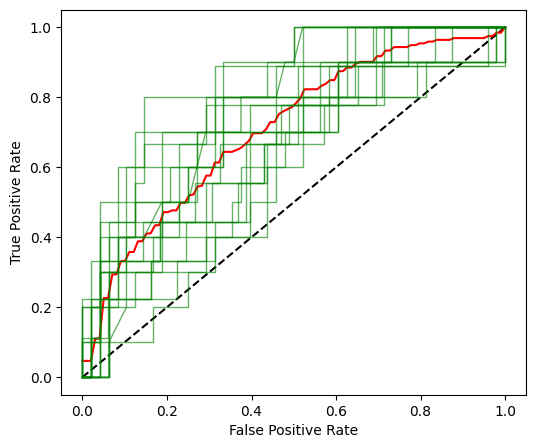

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

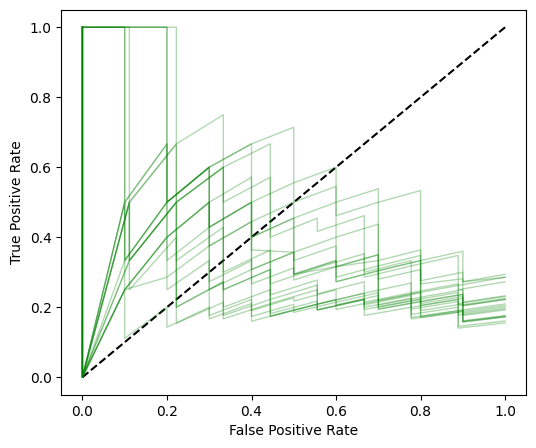

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

# 1010

In [70]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=10,random_state=seed,n_repeats=10)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    #SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(j,'번째')
    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
0 번째
Youden index threshold :  0.21776949738598336
roc_auc_score :  0.6166666666666667
acc :  0.5862068965517241
sensitivity :  0.8
specificity :  0.5416666666666666
pr_auc :  0.2217063492063492 

[[13 11]
 [ 1  4]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
1 번째
Youden index threshold :  0.5027262962895995
roc_auc_score :  0.8416666666666666
acc :  0.7586206896551724
sensitivity :  1.0
specificity :  0.7083333333333334
pr_auc :  0.610465367965368 

[[17  7]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
2 번째
Youden index threshold :  0.29237244415687313
roc_auc_score :  0.9333333333333333
acc :  0.896551724137931
sensitivity :  1.0
specificity :  0.875
pr_auc :  0.6729761904761904 

[[21  3]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
3 번째
Youden index threshold :  0.34461812442293654
roc_auc_score :  0.875
acc :  0.896551724137931
sensitivity :  0.8
specificity : 

In [71]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.7033875
re_score 0.797
specifi_score 0.6939666666666666


[0.6166666666666667,
 0.8416666666666666,
 0.9333333333333333,
 0.875,
 0.8583333333333334,
 0.49166666666666664,
 0.775,
 0.5833333333333333,
 0.8200000000000001,
 0.5208333333333334,
 0.5,
 0.7583333333333334,
 0.7333333333333333,
 0.7583333333333333,
 0.7916666666666667,
 0.7833333333333333,
 0.8,
 0.625,
 0.87,
 0.7708333333333333,
 0.5916666666666667,
 0.7666666666666667,
 0.525,
 0.4916666666666667,
 0.4083333333333333,
 0.8083333333333333,
 0.7583333333333334,
 0.6416666666666666,
 0.75,
 0.8645833333333334,
 0.7583333333333333,
 0.6833333333333333,
 0.6583333333333333,
 0.9083333333333333,
 0.75,
 0.5916666666666668,
 0.625,
 0.5666666666666667,
 0.9000000000000001,
 0.7395833333333334,
 0.5333333333333334,
 0.6000000000000001,
 0.8416666666666667,
 0.8166666666666667,
 0.8083333333333333,
 0.7833333333333334,
 0.6583333333333334,
 0.725,
 0.81,
 0.5208333333333334,
 0.75,
 0.4833333333333333,
 0.675,
 0.75,
 0.675,
 0.7833333333333334,
 0.5666666666666667,
 0.8583333333333334,

In [72]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP


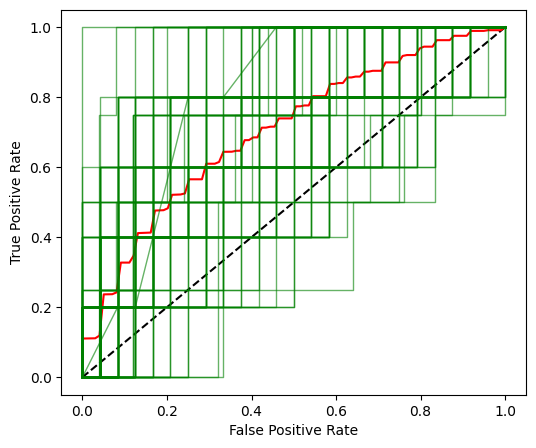

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

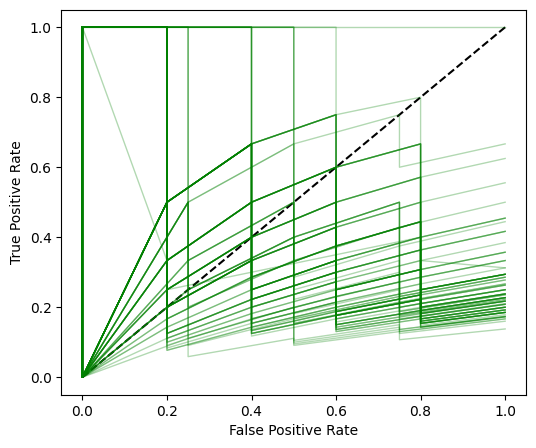

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

In [75]:
CF_item = pd.DataFrame()
CF_item['proba_score'] = proba_score
CF_item['re_score'] = re_score
CF_item['specifi_score'] = specifi_score 
CF_item.to_csv('Autoencoder_최종_SMOTE1010.csv',index=False)